## PIPELINE FEATURE ENGINEERING + MODEL TRAINING VIA RandSCV + TESTING + MODEL SAVING TO JOBLIB

### Preprocessing : partie train test split -> saving train and test sets

In [45]:
# train test split  -> to save in 03
import pandas as pd
from sklearn.model_selection import train_test_split

PATH_TO_INTERMEDIATE_XLSX = r"../data/02_intermediate/df_cleaned.xlsx"
PATH_TO_TRAIN = r"../data/03_primary/train.xlsx"
PATH_TO_TEST = r"../data/03_primary/test.xlsx"


target = 'Sleep Duration' # float : is target

features_retenues = [
    'Gender',  # one hot 
    'Age', # float
    'Occupation', # one hot / nominal avec other
    'Physical Activity Level', # float
    'Stress Level', # float 
    'BMI Category', # est la categorie ipc ordinal encoder
    'High_pressure', # float
    'Low_pressure', # float
    'Heart Rate', # int
    'Daily Steps', # int
    'Sleep Disorder' # one hot 
]

df = pd.read_excel(PATH_TO_INTERMEDIATE_XLSX)
X = df[features_retenues]
print(X.columns)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(df[features_retenues], df[target], test_size=0.2, random_state=2309)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, sep=' | ')
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

with pd.ExcelWriter(PATH_TO_TRAIN) as writer1:
        train.to_excel(writer1)
        print('Saved train data.')

with pd.ExcelWriter(PATH_TO_TEST) as writer2:
        test.to_excel(writer2)
        print('Saved test data.')


Index(['Gender', 'Age', 'Occupation', 'Physical Activity Level',
       'Stress Level', 'BMI Category', 'High_pressure', 'Low_pressure',
       'Heart Rate', 'Daily Steps', 'Sleep Disorder'],
      dtype='object')
(299, 11) | (75, 11) | (299,) | (75,)
Saved train data.
Saved test data.


### Preprocessing : Feature Engineering Pipeline 

On va sélectionner certaines variables pour la modélisation (choix arbitraire pour le moment). Chacune d'elle sera encodée de manière spécifique selon la nature. Pour cela on va se servir des classes BaseEstimator et TransformerMixin de sklearn pour créer des classes d'encoders. L'objectif est de nous simplifier la tâche (reproductibilité) lors de la phase de déploiement. Pour cette raison nous limitons au max l'utilisation de fonctions.   

In [46]:
train = pd.read_excel(PATH_TO_TRAIN)
test = pd.read_excel(PATH_TO_TEST)
print(test.columns)
train = train.set_index('Unnamed: 0')[features_retenues + [target]]
test = test.set_index('Unnamed: 0')[features_retenues]

to_noe = ['Occupation']
to_orde = ['BMI Category']
to_ohe = ['Gender', 'Sleep Disorder']
to_cast_in_float = ['Age', 'Physical Activity Level', 'Stress Level', 'High_pressure', 'Low_pressure']
to_cast_in_int = ['Heart Rate', 'Daily Steps']

Index(['Unnamed: 0', 'Gender', 'Age', 'Occupation', 'Physical Activity Level',
       'Stress Level', 'BMI Category', 'High_pressure', 'Low_pressure',
       'Heart Rate', 'Daily Steps', 'Sleep Disorder', 'Sleep Duration'],
      dtype='object')


#### création de 4 Encoders

In [47]:
from itertools import product
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from dstoolbox.pipeline import DataFrameFeatureUnion
from sklearn.pipeline import Pipeline


class FloatEncoder(BaseEstimator, TransformerMixin):
    """
    Ce transformer va caster les variables "to_cast_in_float" en float 
    """
    def __init__(self, columns_to_transform = None):
        super().__init__()
        self.columns_to_transform = columns_to_transform

    def fit(self, X, y = None):
        if self.columns_to_transform is not None :
            self.X = X[self.columns_to_transform]
        return self # on n'estime rien - limite on peut utiliser assert X[col] is not str pour preparer le codage au float

    def transform(self, X):
        for col in self.columns_to_transform:
            self.X[col] = self.X[col].astype(float)
        return self.X
    
class IntEncoder(BaseEstimator, TransformerMixin):
    """
    Ce transformer va caster les variables "to_cast_in_float" en float 
    """
    def __init__(self, columns_to_transform = None):
        super().__init__()
        self.columns_to_transform = columns_to_transform

    def fit(self, X, y = None):
        if self.columns_to_transform is not None :
            self.X = X[self.columns_to_transform]
        return self 
    
    def transform(self, X):
        for col in self.columns_to_transform:
            self.X[col] = self.X[col].astype(int)
        return self.X

class OneHotEncoderPandas(BaseEstimator, TransformerMixin):
    """
    Cette implémentation du OneHotEncoder renvoie un DataFrame en sortie et non un array numpy. Ceci est fait pour garantir la
    traçabilité des variables et faciliter l'interprétation du modèle dans la suite.
    """
    def __init__(self, columns = None):
        super().__init__()
        self.columns = columns
        self.ohe = OneHotEncoder(handle_unknown= "ignore", sparse = False) #, drop='first')

    def fit(self, X, y = None):
        if self.columns is not None:
            self.X = X[self.columns]
        # on fit l'encoder one hot
        self.ohe.fit(self.X)

        # Récupération des noms de colonnes + categories pour l'interprétabilité
        # Ex : "situation_-1", "situation_10", etc..
        self.feature_category_pairs = []
        for i, feature in enumerate(self.ohe.feature_names_in_):
            feature_category = product([feature], self.ohe.categories_[i])
            for pair in feature_category:
                self.feature_category_pairs.append("{}_{}".format(*pair))
        return self
    
    def transform(self, X):
        if self.columns is not None:
            self.X = X[self.columns]
            
        return pd.DataFrame(self.ohe.transform(self.X), columns = self.feature_category_pairs)


class OrdinalEncoderPandas(BaseEstimator, TransformerMixin):
    """
    Cette implémentation du OrdinalEncoder renvoie un DataFrame en sortie et non un array numpy. Ceci est fait pour garantir la
    traçabilité des variables et faciliter l'interprétation du modèle dans la suite.
    """
    def __init__(self, columns = None):
        super().__init__()
        self.columns = columns
        self.orde = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=999, encoded_missing_value=9999)

    def fit(self, X, y = None):
        if self.columns is not None :
            self.X = X[self.columns]
        
        self.orde.fit(self.X) # ICI
        return self

    def transform(self, X):
        if self.columns is not None:
            X = X[self.columns]      # ICI
        return pd.DataFrame(self.orde.transform(X), columns = self.columns)
        

feature_pipeline = DataFrameFeatureUnion([
    ('OneHotEncoding', OneHotEncoderPandas(columns=to_ohe)),
    ('OrdinalEncoding', OrdinalEncoderPandas(columns=to_orde)),
    ('FloatEnconding', FloatEncoder(columns_to_transform=to_cast_in_float)),
    ('IntEnconding', IntEncoder(columns_to_transform=to_cast_in_int))
], verbose=True)

### Pipeline du Modele : Randomized SearchCV + Random Forest Reg

In [48]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import warnings
import numpy as np
from joblib import load, dump

warnings.filterwarnings('ignore')
param_rf = {
    'n_estimators' : [int(x) for x in np.linspace(10, 80, 10)], # nombre d'arbres dans la forêt 10 20 30 ..
    'max_depth' : [2, 4], # nombre max de niveaux dans un arbre 
    'min_samples_split' : [2, 3], # nombre min d'echantillons (bootstrap) necessaire au niveau d'un noeud pour juger de le spliter 
    'min_samples_leaf' : [1, 2], # nombre min de samples requis à chaque node 
    'max_features' : ['auto', 'sqrt'] # nombre de features à considérer auto = et sqrt = 
}

rcv = RandomizedSearchCV(RandomForestRegressor(), 
                        param_distributions=param_rf, 
                        cv = 4, 
                        n_jobs = 10,
                        random_state = 2309)

# La recherche d'hyperparamètres est effectuée par "Random Search" car plus efficace que la Grid Search à nombre d'itérations fixé.
# Le critère de sélection est la "MSE".


def build_pipeline(model):
    """
    Fonction pour construire la pipeline de prédiction, le paramètre model doit être une instance d'un modèle type scikit-learn.
    """
    ML_pipeline = Pipeline(
        [
            ('FeatureEngineering', feature_pipeline),
            ("Model", model)
        ]
    )

    return ML_pipeline


# La recherche d'hyperparamètres est effectuée par "Random Search" car plus efficace que la Grid Search à nombre d'itérations fixé.

pipeline = build_pipeline(rcv)

pipeline.fit(X_train, y_train)

dump(rcv.best_estimator_, "../data/07_model_output/best_model.joblib")
print(f'Model saved : {rcv.best_params_}')

Model saved : {'n_estimators': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 4}


In [53]:
pipeline

Pipeline(steps=[('FeatureEngineering',
                 DataFrameFeatureUnion(transformer_list=[('OneHotEncoding',
                                                          OneHotEncoderPandas(columns=['Gender',
                                                                                       'Sleep '
                                                                                       'Disorder'])),
                                                         ('OrdinalEncoding',
                                                          OrdinalEncoderPandas(columns=['BMI '
                                                                                        'Category'])),
                                                         ('FloatEnconding',
                                                          FloatEncoder(columns_to_transform=['Age',
                                                                                             'Physical '
                                                                                             'Activity '
                                                                                             'Level',
                                                                                             'Stress '
                                                                                             'Level',
                                                                                             'High_pressure',
                                                                                             'Low_pre...
                                                         ('IntEnconding',
                                                          IntEncoder(columns_to_transform=['Heart '
                                                                                           'Rate',
                                                                                           'Daily '
                                                                                           'Steps']))],
                                       verbose=True)),
                ('Model',
                 RandomizedSearchCV(cv=4, estimator=RandomForestRegressor(),
                                    n_jobs=10,
                                    param_distributions={'max_depth': [2, 4],
                                                         'max_features': ['auto',
                                                                          'sqrt'],
                                                         'min_samples_leaf': [1,
                                                                              2],
                                                         'min_samples_split': [2,
                                                                               3],
                                                         'n_estimators': [10,
                                                                          17,
                                                                          25,
                                                                          33,
                                                                          41,
                                                                          48,
                                                                          56,
                                                                          64,
                                                                          72,
                                                                          80]},
                                    random_state=2309))])

#### Evaluation du modele : train + test -> RMSE


Evaluate Best Random forest RCV regressor
['Gender_Female' 'Gender_Male' 'Sleep Disorder_Insomnia'
 'Sleep Disorder_None' 'Sleep Disorder_Sleep Apnea' 'BMI Category' 'Age'
 'Physical Activity Level' 'Stress Level' 'High_pressure' 'Low_pressure'
 'Heart Rate' 'Daily Steps']
Train error : 0.094
Test error : 0.099


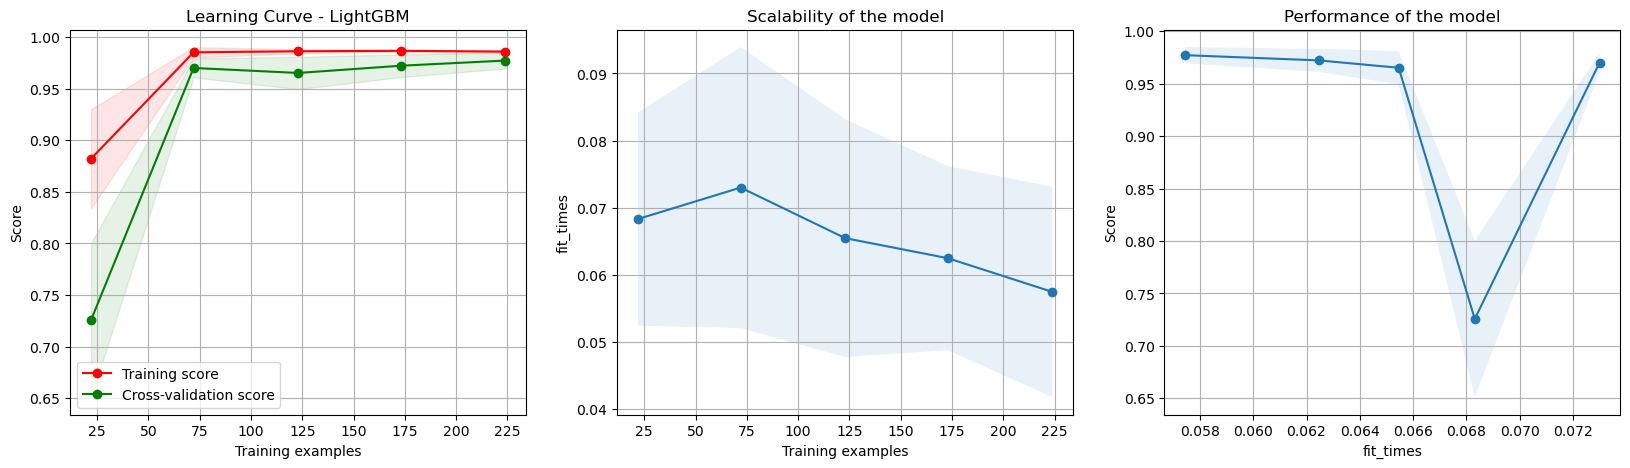

In [49]:
from sklearn.metrics import mean_squared_error
from utils_sleep import plot_learning_curve


def evaluate_model(model, train_features, test_features, train_target, test_target, rep = False):

    prepPipeline = Pipeline([('prepare', feature_pipeline)])
    train_features = prepPipeline.fit_transform(train_features)
    print(train_features.columns.values)
    test_features = prepPipeline.fit_transform(test_features)

    train_preds = model.predict(train_features)
    rmse_train = round(mean_squared_error(train_target, train_preds, squared=False), 3)

    test_preds = model.predict(test_features)
    rmse_test = round(mean_squared_error(test_target, test_preds, squared=False), 3)

    if rep :
        return rmse_train, rmse_test
    else : 
        print("="*50)
        print("Train error :",rmse_train) 
        print("Test error :", rmse_test)

    #======== LEARNING CURVE
    plot_learning_curve(
        best_model,
        title = "Learning Curve - LightGBM",
        X = train_features,
        y = train_target,
        cv=4,
        n_jobs=1,
    )


# execution

PATH_TO_MODEL = r"..\data\07_model_output\best_model.joblib"
best_model = load(PATH_TO_MODEL)

print("\nEvaluate Best Random forest RCV regressor")
evaluate_model(best_model, X_train, X_test, y_train, y_test)

### Others

In [50]:
X_train.columns.values

array(['Gender', 'Age', 'Occupation', 'Physical Activity Level',
       'Stress Level', 'BMI Category', 'High_pressure', 'Low_pressure',
       'Heart Rate', 'Daily Steps', 'Sleep Disorder'], dtype=object)

In [51]:
X_test.dtypes

Gender                     object
Age                         int64
Occupation                 object
Physical Activity Level     int64
Stress Level                int64
BMI Category               object
High_pressure               int64
Low_pressure                int64
Heart Rate                  int64
Daily Steps                 int64
Sleep Disorder             object
dtype: object

In [52]:
X_test.median().T

Age                          43.0
Physical Activity Level      60.0
Stress Level                  5.0
High_pressure               130.0
Low_pressure                 85.0
Heart Rate                   70.0
Daily Steps                7000.0
dtype: float64

In [10]:
pipeline

Pipeline(steps=[('FeatureEngineering',
                 DataFrameFeatureUnion(transformer_list=[('OneHotEncoding',
                                                          OneHotEncoderPandas(columns=['Gender',
                                                                                       'Sleep '
                                                                                       'Disorder'])),
                                                         ('OrdinalEncoding',
                                                          OrdinalEncoderPandas(columns=['BMI '
                                                                                        'Category'])),
                                                         ('FloatEnconding',
                                                          FloatEncoder(columns_to_transform=['Age',
                                                                                             'Physical '
                                                                                             'Activity '
                                                                                             'Level',
                                                                                             'Stress '
                                                                                             'Level',
                                                                                             'High_pressure',
                                                                                             'Low_pre...
                                                         ('IntEnconding',
                                                          IntEncoder(columns_to_transform=['Heart '
                                                                                           'Rate',
                                                                                           'Daily '
                                                                                           'Steps']))],
                                       verbose=True)),
                ('Model',
                 RandomizedSearchCV(cv=4, estimator=RandomForestRegressor(),
                                    n_jobs=10,
                                    param_distributions={'max_depth': [2, 4],
                                                         'max_features': ['auto',
                                                                          'sqrt'],
                                                         'min_samples_leaf': [1,
                                                                              2],
                                                         'min_samples_split': [2,
                                                                               3],
                                                         'n_estimators': [10,
                                                                          17,
                                                                          25,
                                                                          33,
                                                                          41,
                                                                          48,
                                                                          56,
                                                                          64,
                                                                          72,
                                                                          80]},
                                    random_state=2309))])

In [20]:
known_categories = ['2014','2015','2016','2017','2018']    
year_type = pd.Series(['2018']) 
year_type

0    2018
dtype: object

In [21]:
year_type = pd.Categorical(year_type, categories = known_categories)
year_type

['2018']
Categories (5, object): ['2014', '2015', '2016', '2017', '2018']

In [29]:
pd.get_dummies(year_type)


,2014,2015,2016,2017,2018
0,0,0,0,0,1


In [37]:
pd.concat([pd.DataFrame([1], columns=['2018'], index=[0]), pd.get_dummies(year_type)], ignore_index=False)

,2018,2014,2015,2016,2017
0,1,NaN,NaN,NaN,NaN
0,1,0.0,0.0,0.0,0.0


In [39]:
assert(X_test.shape) == (75, 11)